In [1]:
import matplotlib.pyplot as plt
import matplotlib

EJERCICIO PRESTADO AL SR CARISIMO A FIUBA POR FCEN

En una conexión TCP recién establecida (IW = 2 * MSS,
SSTHRESH = 64KB) con RTT=200ms y MSS=2KB, el host
receptor siempre anuncia una AdvertisedWindow de 16KB.
La red está cargada al punto que si una ráfaga fuera de
16KB o mas, se perderían todos los segmentos de la misma.
¿Cuántos rounds se demora en enviar un archivo de 40KB? 

In [2]:
IW = 2

In [3]:
import math

class CongestionSimulator():
    
    def __init__(self, iw, ssthreshold, limit, mss):
        '''
        iw: initial window (en unidad de MSS)
        ssthreshold: threshold inicial (en unidad de MSS)
        limit: el limite para el cual se pierden todos los paquetes (en KB)
        MSS: tamaño del MSS (en KB)
        '''
        self.window_size = iw
        self.threshold = ssthreshold
        self.limit = limit
        self.mss = mss
    
    def update_window_size(self, acks_received):
        def slow_start(windows_size):
            return windows_size+1

        def congestion_avoidance(window_size):
            return window_size+(1/window_size)

        if acks_received==0:
            self.window_size = 1
        temp_ws = self.window_size
        for _ in range(acks_received):
            if temp_ws<self.threshold:
                temp_ws = slow_start(temp_ws)
            else:
                temp_ws = congestion_avoidance(temp_ws)
        self.window_size = temp_ws

    def send_burst(self, last_segment_acked, size):
        '''
        last_segment_acked: el ultimo segmento por el que se recibio un ack
        size: los kb de lo que se esta transmitiendo
        
        Sends a burst and returns the communication array, the ack count and the last segment with ack
        '''
        int_ws = int(math.floor(self.window_size))
        upper_bound=last_segment_acked+int_ws
        if upper_bound>=size//self.mss:
            upper_bound=size//self.mss
        out_communication = [(i, 0) for i in range(last_segment_acked+1,upper_bound+1)]
        if int_ws*self.mss>=self.limit and size-last_segment_acked*self.mss>=self.limit:
            return [out_communication], 0, last_segment_acked
        in_communication = [(i, -1) for i in range(last_segment_acked+1,upper_bound+1)]
        return [out_communication+in_communication], int_ws, upper_bound
    
    def simulate(self, size_to_transmit):
        '''
        size_to_transmit: el tamanio a transmitir en kb
        
        Devuelve una tupla con una lista de comunicacion, 
        lista de window sizes, y lista de tresholds
        '''
        last_segment_acked=0
        comm=[]
        window_sizes=[]
        tresholds=[]
        while True:
            aux_comm,acks,last_segment_acked = self.send_burst(last_segment_acked,size_to_transmit)
            comm+=aux_comm
            window_sizes.append(self.window_size)
            tresholds.append(self.threshold)
            if acks==0:
                self.threshold=max(2*self.mss,self.window_size//2)
            self.update_window_size(acks)
            if last_segment_acked==size_to_transmit//self.mss:
                break
        return comm, window_sizes, tresholds

In [4]:
simulator = CongestionSimulator(IW,32,16,2)
comm, window_sizes, tresholds = simulator.simulate(40)

In [5]:
ARROWS_SEPARATOR=10
ANSWER_SEPARATOR=10
RTO_SEPARATOR=60
X_DISTANCE=100
Y_DISTANCE=1000
COLOR="dodgerblue"
FONTSIZE=12

(-5.0, 105.0, -50.0, 1050.0)

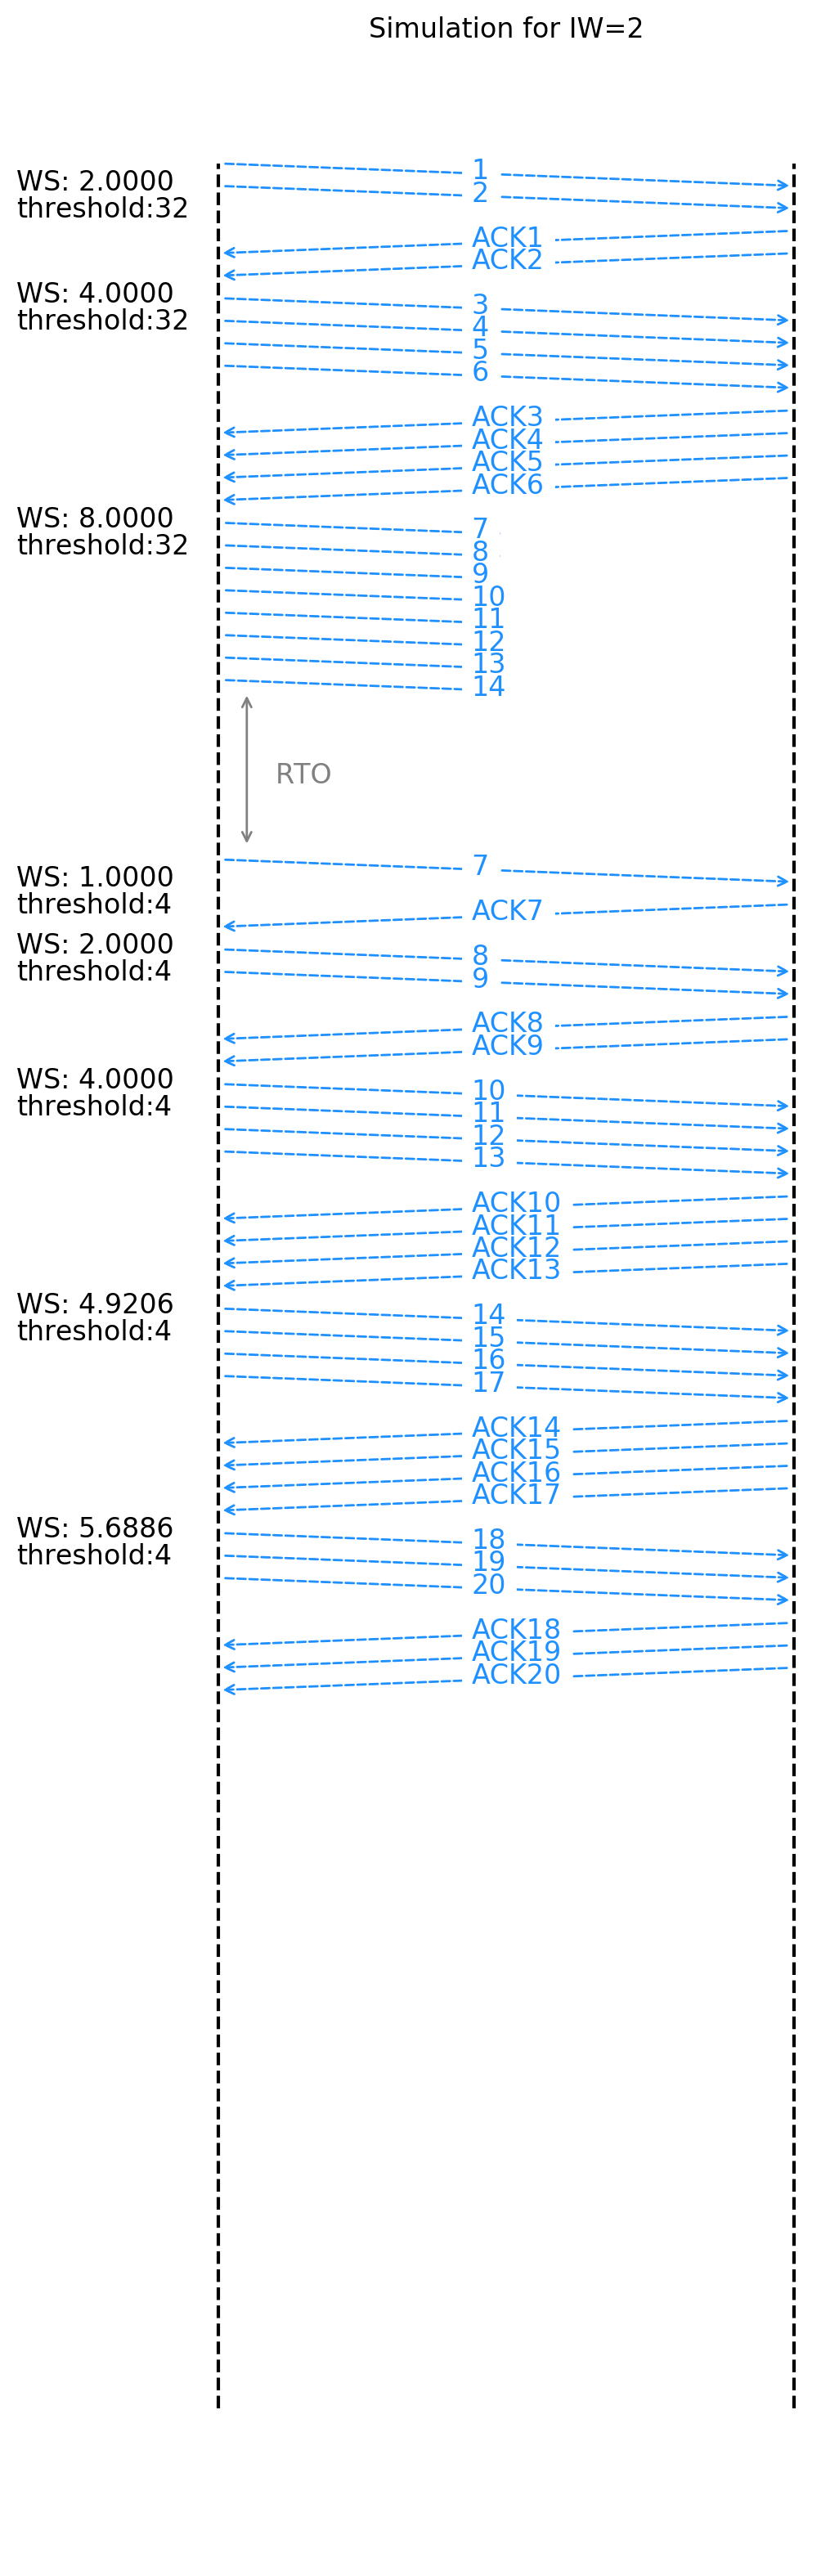

In [6]:
plt.figure(figsize=[5,20],dpi=200)
ax = plt.axes()
ax.plot((0,0),(0,Y_DISTANCE), color="black", linestyle="--")
ax.plot((X_DISTANCE,X_DISTANCE),(0,Y_DISTANCE), color="black", linestyle="--")
actual_position=Y_DISTANCE
response_started=False
for seq,ws,thr in zip(comm,window_sizes,tresholds):
    if sum([1 for x in seq if x[-1]==-1])==0:
        divisor=2
    else:
        divisor=1
    ax.text(-35,actual_position-FONTSIZE, "WS: %.4f"%ws, color='black', fontsize=FONTSIZE,zorder=1)
    ax.text(-35,actual_position-2*FONTSIZE, "threshold:"+str(thr), color='black', fontsize=FONTSIZE,zorder=1)
    for signal in seq:
        if signal[-1]==-1:
            if not response_started:
                actual_position-=ANSWER_SEPARATOR
            response_started=True
            ax.annotate(s='', xy=(X_DISTANCE,actual_position), xytext=(0,actual_position-ARROWS_SEPARATOR//divisor), 
                         arrowprops=dict(arrowstyle='<-', color=COLOR, linestyle='--'), zorder=0)
            ax.text(X_DISTANCE//2-FONTSIZE//2,actual_position+ARROWS_SEPARATOR//2-FONTSIZE, "ACK"+str(signal[0]), color='white', fontsize=FONTSIZE, 
                    bbox=dict(facecolor='white', alpha=1, edgecolor="white"),zorder=1)
            ax.text(X_DISTANCE//2-FONTSIZE//2,actual_position+ARROWS_SEPARATOR//2-FONTSIZE, "ACK"+str(signal[0]), color=COLOR, fontsize=FONTSIZE,zorder=2)
        else:
            if response_started:
                actual_position-=ANSWER_SEPARATOR
            response_started=False
            ax.annotate(s='', xy=(0,actual_position), xytext=(X_DISTANCE//divisor,actual_position-ARROWS_SEPARATOR//divisor), 
                        arrowprops=dict(arrowstyle='<-', color=COLOR, linestyle='--'), zorder=0)
            ax.text(X_DISTANCE//2-FONTSIZE//2,actual_position+ARROWS_SEPARATOR//2-FONTSIZE, str(signal[0]), color='white', fontsize=FONTSIZE, 
                    bbox=dict(facecolor='white', alpha=1, edgecolor="white"),zorder=1)
            ax.text(X_DISTANCE//2-FONTSIZE//2,actual_position+ARROWS_SEPARATOR//2-FONTSIZE, str(signal[0]), color=COLOR, fontsize=FONTSIZE,zorder=2)
        actual_position-=ARROWS_SEPARATOR
    if divisor==2:
            ax.annotate(s='', xy=(ARROWS_SEPARATOR//2,actual_position+ARROWS_SEPARATOR//2), 
                        xytext=(ARROWS_SEPARATOR//2,actual_position-RTO_SEPARATOR-ARROWS_SEPARATOR//2), 
                        arrowprops=dict(arrowstyle='<->', color='grey', linestyle='-'), zorder=0)
            ax.text(ARROWS_SEPARATOR,actual_position-RTO_SEPARATOR//2-FONTSIZE//2, 
                    "RTO", color='grey', fontsize=FONTSIZE)
            actual_position-=ARROWS_SEPARATOR+RTO_SEPARATOR
plt.title("Simulation for IW="+str(IW))
plt.axis('off')